<a href="https://colab.research.google.com/github/jo-adithya/computer-vision-experiments/blob/main/notebooks/02_building_computer_vision_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

### Setup device-agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get the data

The dataset is a subset of the `Animals10` dataset from kaggle by Corrado Alessi.

The original `Animals10` contain 10 different classes of animals.

This dataset starts with 4 classes of animals and only limit to 1500 images per class (~1350 images for training, ~150 images for testing).

See link, for the data cleaning process.

In [ ]:
import requests
import zipfile
from pathlib import Path

In [ ]:
# Store all the important paths in variable
dataset_name = "animals_4"
data_path = Path("data")
dataset_path = data_path / dataset_name

In [ ]:
# Download the cleaned animals_4 dataset
zip_file_path = data_path / f"{dataset_name}.zip"
if dataset_path.is_dir():
    print(f"{dataset_path} dataset already exists, skipping download...")
else:
    print(f"{dataset_path} dataset doesn't exist, downloading the {dataset_path.name} dataset...")
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Download the dataset
    with open(zip_file_path, "wb") as f:
        print(f"Downloading {dataset_name} dataset...")
        request = requests.get("https://github.com/jo-adithya/computer-vision-experiments/raw/main/data/animals_4.zip")
        f.write(request.content)

    # Unzip the data
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        print(f"Unzipping {dataset_name} dataset...")
        zip_ref.extractall(dataset_path)

data/animals_4 dataset doesn't exist, downloading the animals_4 dataset...
Unzipping animals_4 dataset...


## 2. Data preparation and data exploration

In [ ]:
import os

In [ ]:
def print_dir_info(dir_path: Path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} in '{dirpath}'")

In [ ]:
print_dir_info(dataset_path)

There are 2 directories and 0 in 'data/animals_4'
There are 4 directories and 0 in 'data/animals_4/test'
There are 0 directories and 150 in 'data/animals_4/test/dog'
There are 0 directories and 150 in 'data/animals_4/test/chicken'
There are 0 directories and 150 in 'data/animals_4/test/cat'
There are 0 directories and 150 in 'data/animals_4/test/horse'
There are 4 directories and 0 in 'data/animals_4/train'
There are 0 directories and 1350 in 'data/animals_4/train/dog'
There are 0 directories and 1350 in 'data/animals_4/train/chicken'
There are 0 directories and 1350 in 'data/animals_4/train/cat'
There are 0 directories and 1350 in 'data/animals_4/train/horse'


In [ ]:
# Save the test and train path in variables
test_path = dataset_path / "test"
train_path = dataset_path / "train"\

test_path, train_path

(PosixPath('data/animals_4/test'), PosixPath('data/animals_4/train'))

### 2.1 Visualize random image data

In [ ]:
import random
from PIL import Image

In [ ]:
image_list = list(dataset_path.rglob("*.*"))
len(image_list)

6000

In [ ]:
# Set random seed
random.seed(42)

# Select a random image to visualize
random_image_path = random.choice(image_list)
random_image_path

PosixPath('data/animals_4/train/horse/OIP-0PTU5Y7HrEXGPiwTZBXiNQHaHF.jpeg')

In [ ]:
# Get the random image class
random_image_class = random_image_path.parent.name
random_image_class

'horse'

Random image path: data/animals_4/train/horse/OIP-0PTU5Y7HrEXGPiwTZBXiNQHaHF.jpeg
Random image class: horse
Image height: 287
Image width: 300


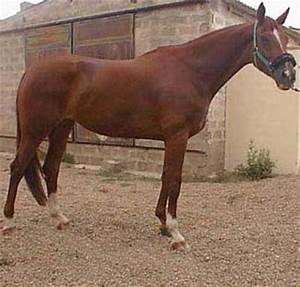

In [ ]:
# Read the image using the PIL library
image = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
image

### 2.2 Visualize image data using Matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_arr = np.asarray(image)

(-0.5, 299.5, 286.5, -0.5)

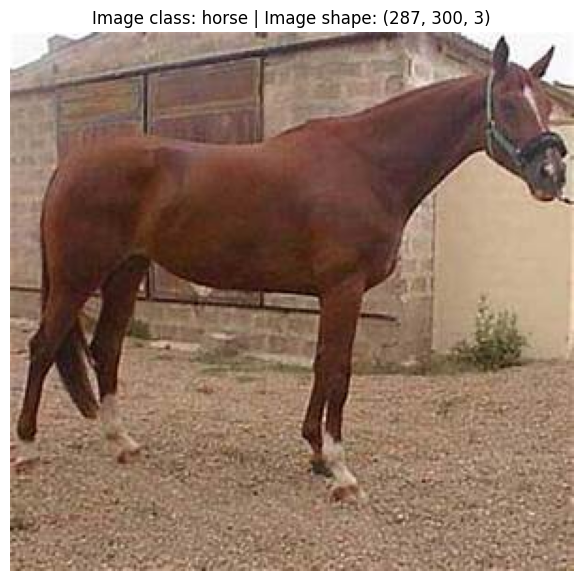

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(image_arr)
plt.title(f"Image class: {random_image_class} | Image shape: {image_arr.shape}")
plt.axis(False)

## 3. Transform image data to tensors

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),           # Resize the image to 64x64 for TinyVGG architecture
    transforms.RandomHorizontalFlip(p=0.5),     #
    transforms.ToTensor()
])

In [ ]:
def plot_transformed_images(image_list: list[Path], transform_fn, n = 3, seed = 42):
    if seed:
        random.seed(seed)
    random_images = random.sample(image_list, k = n)
    for image in random_images:
        with Image.open(image) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original size: {f.size}")
            ax[0].axis(False)

            transformed_image = transform_fn(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed size: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image.parent.name}")


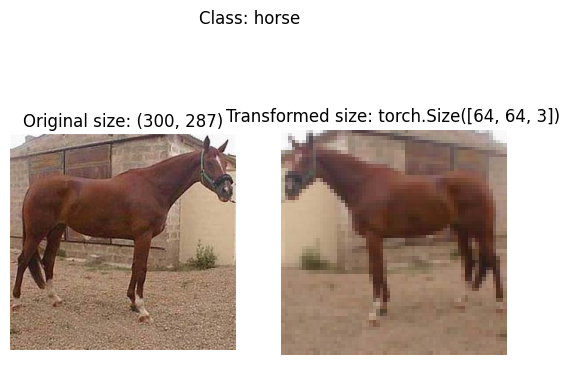

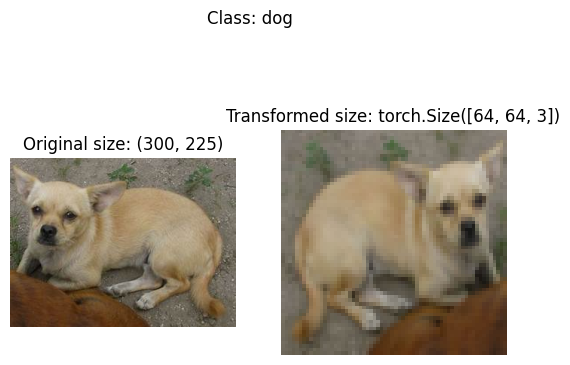

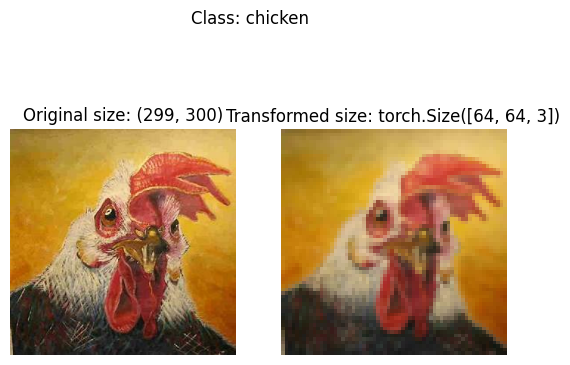

In [ ]:
plot_transformed_images(image_list, data_transform)

## 4. Transform images into tensors using `torchvision.datasets`

In [ ]:
from torchvision import datasets

In [ ]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5400
     Root location: data/animals_4/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 600
     Root location: data/animals_4/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['cat', 'chicken', 'dog', 'horse']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'cat': 0, 'chicken': 1, 'dog': 2, 'horse': 3}

### 4.1 Turn `torchvision.datasets` to `DataLoader`s

In [ ]:
import os
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7968e1dfbca0>,
 <torch.utils.data.dataloader.DataLoader at 0x796904623fa0>)

In [ ]:
# Number of batches
len(train_dataloader), len(test_dataloader)

(169, 19)

### 4.2 Visualize one batch of dataloader

In [ ]:
images, labels = next(iter(train_dataloader))
images.shape, len(labels)

(torch.Size([32, 3, 64, 64]), 32)

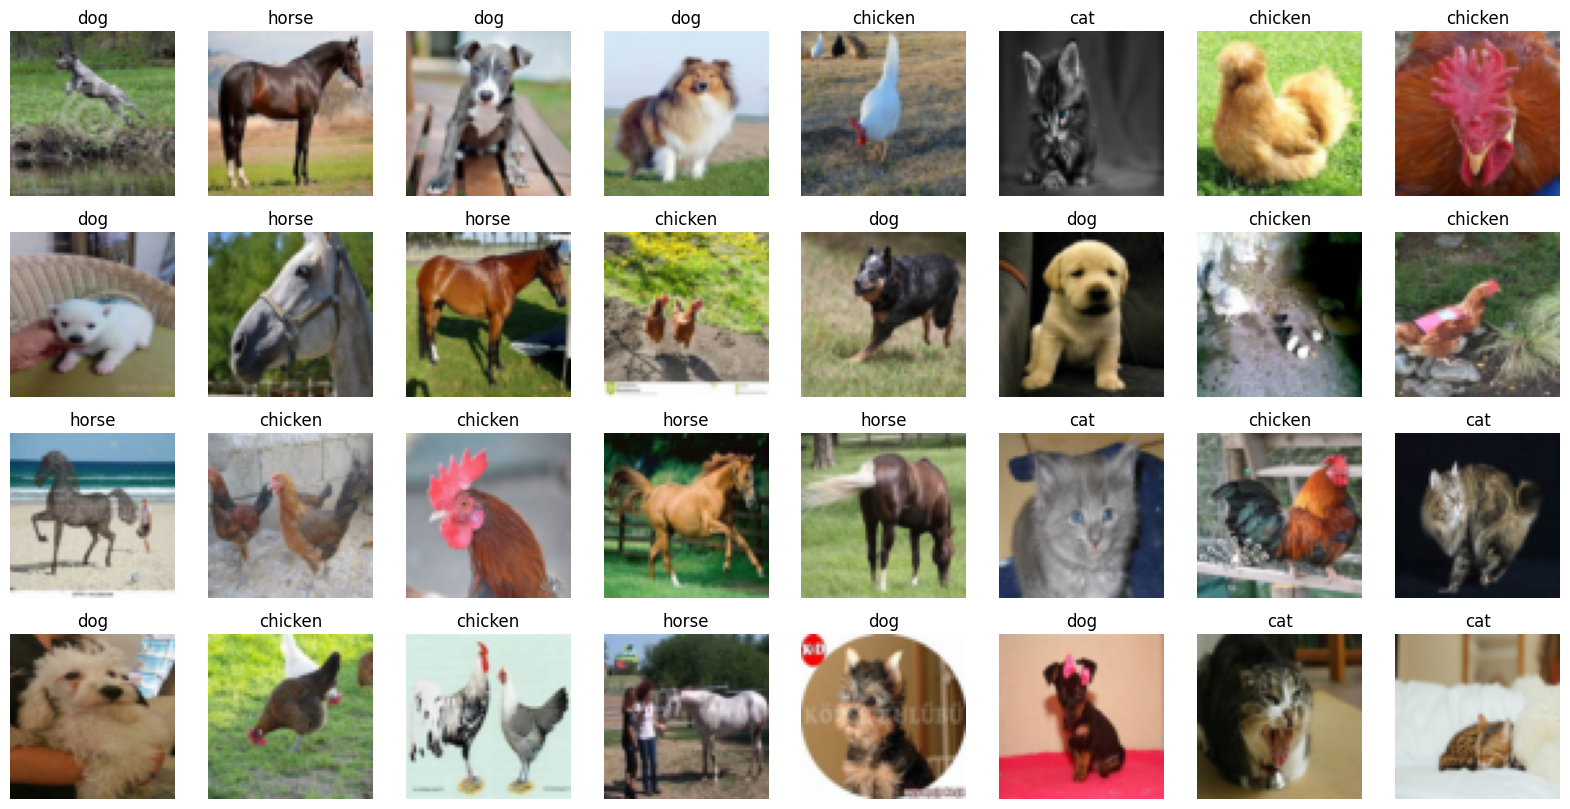

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()

for i in range(len(images)):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis(False)


## 5. Load image data with a custom `Dataset`

In [ ]:
import os
from pathlib import Path
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

from typing import Tuple, Dict, List

In [ ]:
# Here are some functionality of ImageFolder dataset
train_data.classes, train_data.class_to_idx

(['cat', 'chicken', 'dog', 'horse'],
 {'cat': 0, 'chicken': 1, 'dog': 2, 'horse': 3})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()`when the data is in standard image classification format.
2. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path variables
target_path = train_path
print(f"Target path: {target_path}")

target_class_names = sorted([entry.name for entry in os.scandir(target_path)])

print(target_class_names)

Target path: data/animals_4/train
['cat', 'chicken', 'dog', 'horse']


In [ ]:
def find_target_classes(path: Path) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class names for the given dataset/target path."""
    classes = sorted(entry.name for entry in os.scandir(path) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find anyt classes in {path}...")
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_target_classes(target_path)

(['cat', 'chicken', 'dog', 'horse'],
 {'cat': 0, 'chicken': 1, 'dog': 2, 'horse': 3})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
class CustomImageFolder(Dataset):
    def __init__(self, root: str | Path, transform=None):
        self.paths = list(Path(root).glob("*/*.*"))
        self.transform = transform
        self.classes, self.class_to_idx = find_target_classes(Path(root))

    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        """Returns the total number of data samples."""
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data. (data: torch.Tensor, label: int)."""
        image = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(image), class_idx
        else:
            return transforms.ToTensor()(image), class_idx

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = CustomImageFolder(root=train_path,
                                      transform=train_transform)

test_data_custom = CustomImageFolder(root=test_path,
                                     transform=test_transform)


In [ ]:
len(train_data), len(test_data)

(5400, 600)

In [ ]:
len(train_data_custom), len(test_data_custom)

(5400, 600)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx

(['cat', 'chicken', 'dog', 'horse'],
 {'cat': 0, 'chicken': 1, 'dog': 2, 'horse': 3})

### 5.3 Visualize our custom `Dataset`

In [ ]:
from typing import Optional
import math

def display_random_images(dataset: Dataset,
                          classes: Optional[List[str]] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: Optional[int] = None):
    # Set the seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    sample_indexes = random.sample(range(len(dataset)), k=n)

    # Setup matplotlib plot
    nrows = math.ceil(n / 5)
    plt.figure(figsize=(16, 8))

    # Visualize the data!
    for i, sample_index in enumerate(sample_indexes):
        image, label = dataset[sample_index]
        # [color_channels, height, width] -> [height, width, color_channels]
        adjusted_image = image.permute(1, 2, 0)

        plt.subplot(nrows, 5, i + 1)
        plt.imshow(adjusted_image)
        plt.axis("off")

        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title += f"\nShape: {adjusted_image.shape}"
        plt.title(title)



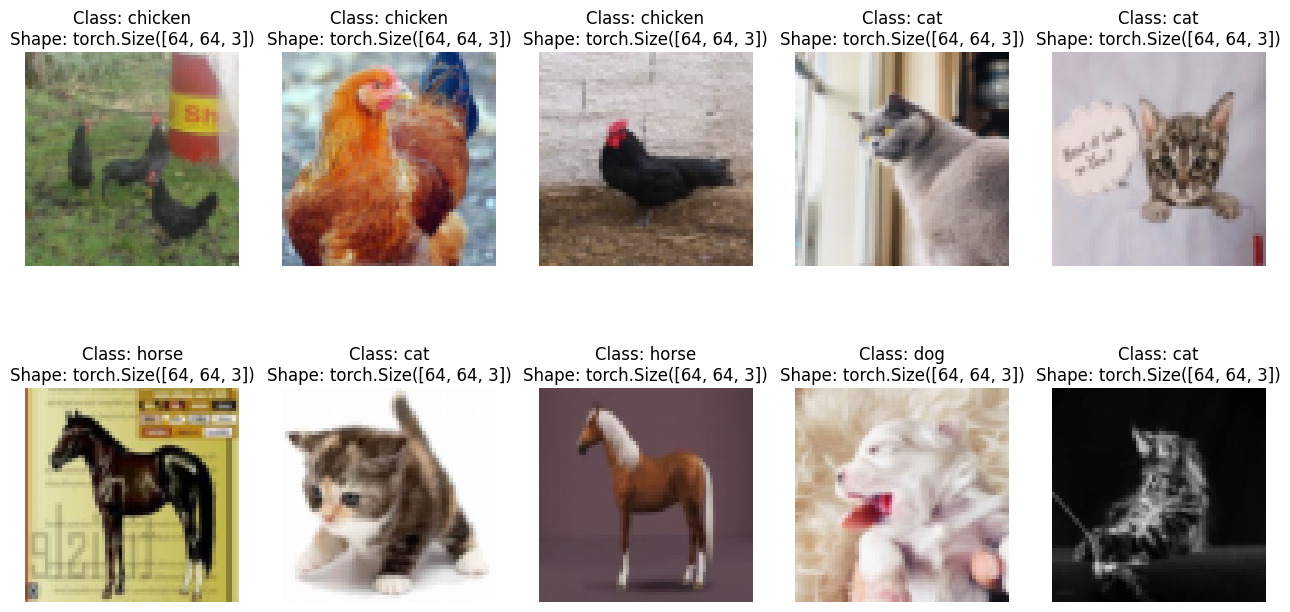

In [ ]:
display_random_images(train_data, n=10, classes=class_names)

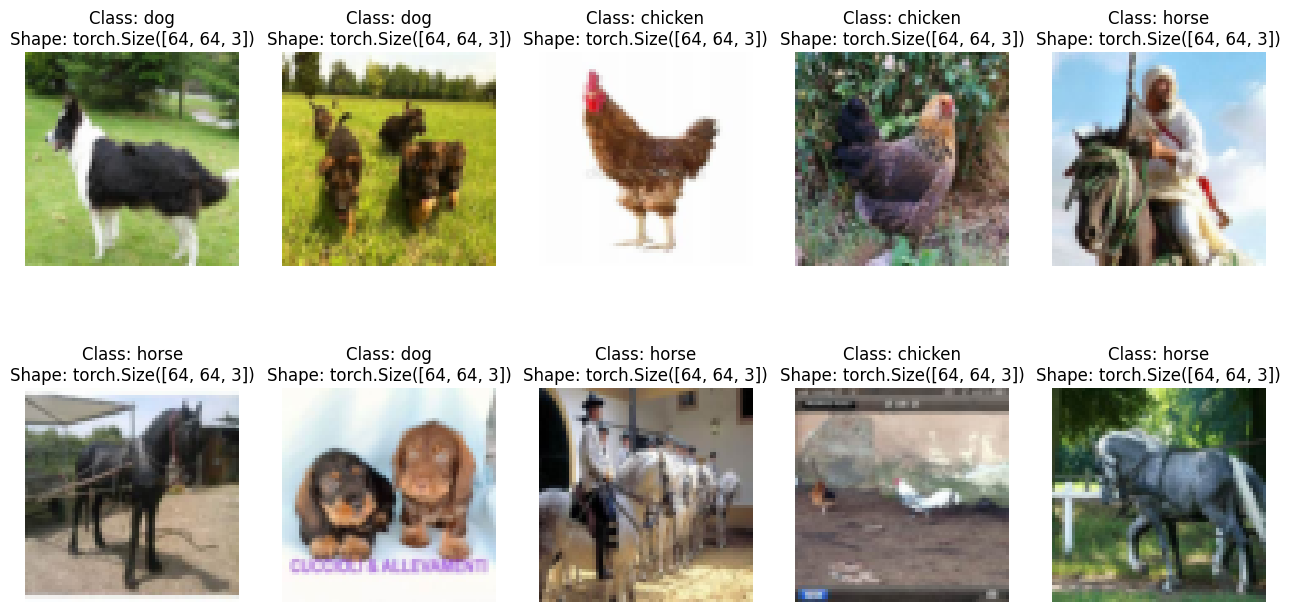

In [ ]:
display_random_images(train_data_custom, n=10, classes=class_names)

### 5.4 Turn custom `Dataset` into `DataLoader`s

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() if os.cpu_count() else 0

In [ ]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [ ]:
image_batch_custom, label_batch_custom = next(iter(train_dataloader_custom))
image_batch_custom.shape, label_batch_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
def visualize_batch_image(image_batch, labels: List[int], classes: List[str]):
    plt.figure(figsize=(20, 10))
    nrows, ncols = 4, 8
    for i in range(len(image_batch)):
        plt.subplot(nrows, ncols, i + 1)
        adjusted_image = image_batch[i].permute(1, 2, 0)
        plt.imshow(adjusted_image)
        plt.title(classes[labels[i]])
        plt.axis(False)


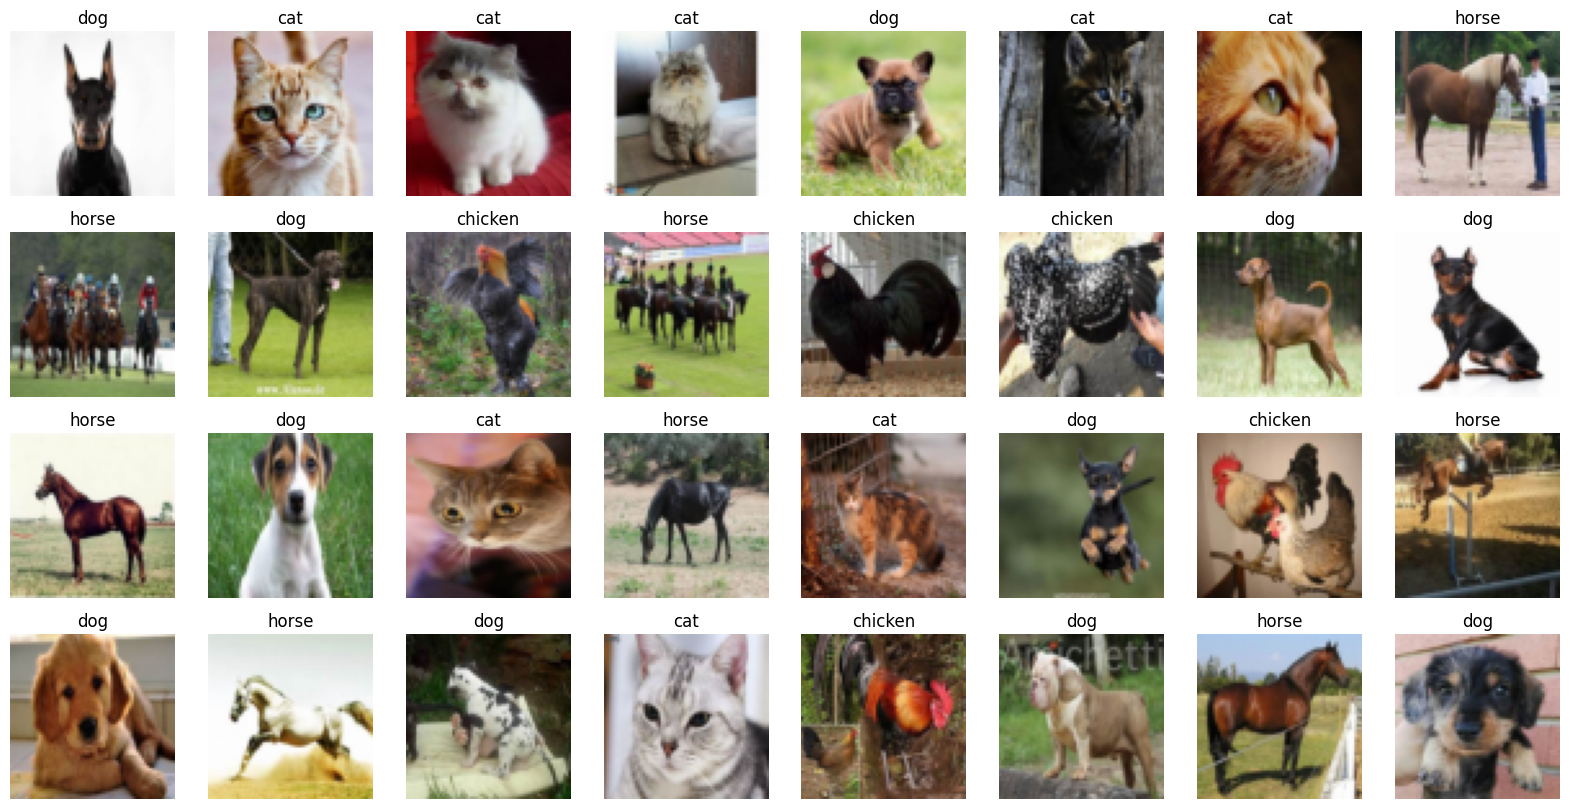

In [ ]:
visualize_batch_image(image_batch=image_batch_custom,
                      labels=label_batch_custom,
                      classes=class_names)

## 6. Building models

### 6.1 Baseline model 0: TinyVGG without data augmentation

#### 6.1.1 Creating transforms and load data for model 0

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# Load and transform data
train_data_simple = datasets.ImageFolder(root=train_path,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_path,
                                        transform=simple_transform)

len(train_data_simple), len(test_data_simple)

(5400, 600)

In [ ]:
# Turn datasets into DataLoaders
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS,
                                     batch_size=BATCH_SIZE)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS,
                                    batch_size=BATCH_SIZE)

len(train_dataloader_simple), len(test_dataloader_simple)

(169, 19)

#### 6.1.2 Create TinyVGG model

In [ ]:
from torch import nn

In [ ]:
class TinyVGGConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.model(x)


class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.conv1 = TinyVGGConvBlock(in_channels=input_shape,
                                      out_channels=hidden_units)
        self.conv2 = TinyVGGConvBlock(in_channels=hidden_units,
                                      out_channels=hidden_units)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13 * 13 * hidden_units,
                      out_features=output_shape),
        )

    def forward(self, x):
        return self.classifier(
            self.conv2(
                self.conv1(x)
            )
        )

#### 6.1.3 Analyse the number of trainable parameters

In [ ]:
try:
    from torchinfo import summary
except:
    print("Torchinfo lib not found, downloading...")
    !pip install torchinfo
    from torchinfo import summary

Torchinfo lib not found, downloading...


In [ ]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

model_0

TinyVGG(
  (conv1): TinyVGGConvBlock(
    (model): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): TinyVGGConvBlock(
    (model): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [ ]:
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─TinyVGGConvBlock: 1-1                  [1, 10, 30, 30]           --
│    └─Sequential: 2-1                   [1, 10, 30, 30]           --
│    │    └─Conv2d: 3-1                  [1, 10, 62, 62]           280
│    │    └─ReLU: 3-2                    [1, 10, 62, 62]           --
│    │    └─Conv2d: 3-3                  [1, 10, 60, 60]           910
│    │    └─ReLU: 3-4                    [1, 10, 60, 60]           --
│    │    └─MaxPool2d: 3-5               [1, 10, 30, 30]           --
├─TinyVGGConvBlock: 1-2                  [1, 10, 13, 13]           --
│    └─Sequential: 2-2                   [1, 10, 13, 13]           --
│    │    └─Conv2d: 3-6                  [1, 10, 28, 28]           910
│    │    └─ReLU: 3-7                    [1, 10, 28, 28]           --
│    │    └─Conv2d: 3-8                  [1, 10, 26, 26]           910
│    │    └

#### 6.1.4 Create train and test loops helper function

In [ ]:
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               debug = False,
               device = device):
    # Setup training mode for the model
    model.train()

    # Setup metrics variables
    train_loss, train_acc = 0, 0

    # Training loop
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate loss
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y)
        loss.backward()

        # Gradient clipping

        # Optimizer step function
        optimizer.step()

        # Compute metrics
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += torch.sum(y_pred_class == y).item() / len(y_pred)

    # Log gradients once per epoch
    if debug:
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"Layer: {name} | Grad Norm: {grad_norm:.6f}")
            else:
                print(f"Layer: {name} | Grad Norm: None")
        print()

    # Calculate the average metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [ ]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device = device):
    # Setup eval mode for the model
    model.eval()

    # Setup metrics variables
    test_loss, test_acc = 0, 0

    # Test loop
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate losses
            loss = loss_fn(y_pred, y)

            # Compute metrics
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += torch.sum(y_pred_class == y).item() / len(y_pred)

        # Calculate the average metrics
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          debug = False,
          device = device):
    # Create training results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}")
        print(f"----------")
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           debug=debug,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc * 100:.1f}%")
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc * 100:.1f}%\n")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

#### 6.1.5 Train and evaluate model 0

In [ ]:
from timeit import default_timer as timer

In [ ]:
NUM_EPOCHS = 5

In [ ]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

model_0

TinyVGG(
  (conv1): TinyVGGConvBlock(
    (model): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): TinyVGGConvBlock(
    (model): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [ ]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Setup optimizer
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Train the model
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f}s")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.3464 | Train acc: 33.4%
Test loss: 1.2761 | Test acc: 43.2%

Epoch: 1
----------
Train loss: 1.2146 | Train acc: 46.0%
Test loss: 1.1377 | Test acc: 51.5%

Epoch: 2
----------
Train loss: 1.1061 | Train acc: 52.7%
Test loss: 1.0585 | Test acc: 56.5%

Epoch: 3
----------
Train loss: 1.0471 | Train acc: 56.2%
Test loss: 1.0028 | Test acc: 56.9%

Epoch: 4
----------
Train loss: 0.9769 | Train acc: 59.3%
Test loss: 0.9725 | Test acc: 61.6%

Total training time: 80.216s


In [ ]:
model_0_results

{'train_loss': [1.3463880931131937,
  1.214588360320887,
  1.1060633987364685,
  1.0470660381768582,
  0.9768790719071789],
 'train_acc': [0.33394970414201186,
  0.45956607495069035,
  0.5269354043392505,
  0.5617603550295858,
  0.5934418145956608],
 'test_loss': [1.276125691438976,
  1.1377224577100653,
  1.0585048041845624,
  1.0028097284467596,
  0.9724707854421515],
 'test_acc': [0.43201754385964913,
  0.5148026315789473,
  0.5652412280701755,
  0.568530701754386,
  0.6156798245614035]}

#### 6.1.6 Plot the loss curves of model 0

In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    train_loss = results["train_loss"]
    train_acc  = results["train_acc"]
    test_loss  = results["test_loss"]
    test_acc   = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss,  label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc,  label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

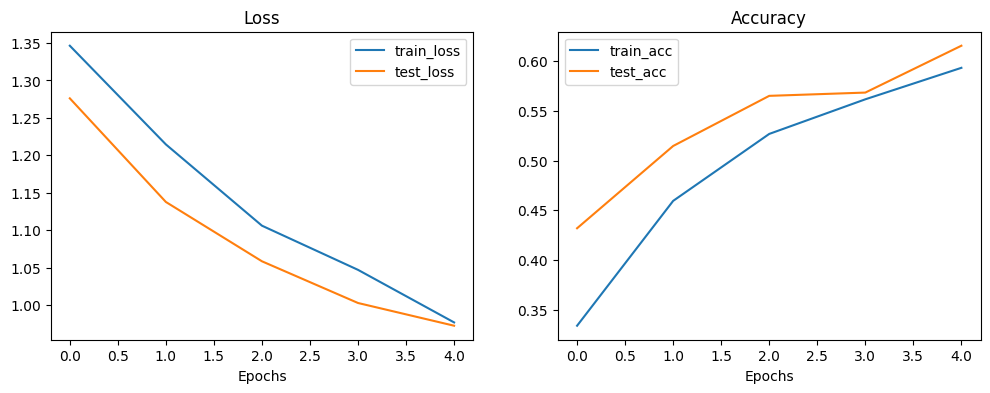

In [ ]:
plot_loss_curves(model_0_results)

### 6.2 Model 1: TinyVGG with data augmentation

#### 6.2.1 Create transform with data augmentation and load data for model 1

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_augmented = datasets.ImageFolder(root=train_path,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_path,
                                        transform=test_transform_simple)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

len(train_dataloader_augmented), len(test_dataloader_simple)

(169, 19)

#### 6.2.2 Train and evaluate model 1

In [ ]:
from timeit import default_timer as timer

In [ ]:
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv1): TinyVGGConvBlock(
    (model): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): TinyVGGConvBlock(
    (model): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [ ]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Setup optimizer
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
# Train the model
NUM_EPOCHS = 5

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()

print(f"Total training time for model_1: {end_time - start_time:.3f}s")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.3855 | Train acc: 26.4%
Test loss: 1.3694 | Test acc: 26.4%

Epoch: 1
----------
Train loss: 1.3648 | Train acc: 31.2%
Test loss: 1.3108 | Test acc: 39.4%

Epoch: 2
----------
Train loss: 1.3129 | Train acc: 36.9%
Test loss: 1.1638 | Test acc: 50.6%

Epoch: 3
----------
Train loss: 1.2439 | Train acc: 42.9%
Test loss: 1.1124 | Test acc: 54.4%

Epoch: 4
----------
Train loss: 1.1824 | Train acc: 47.2%
Test loss: 1.0207 | Test acc: 55.4%

Total training time for model_1: 87.053s


#### 6.2.3 Plot loss curves for model 1

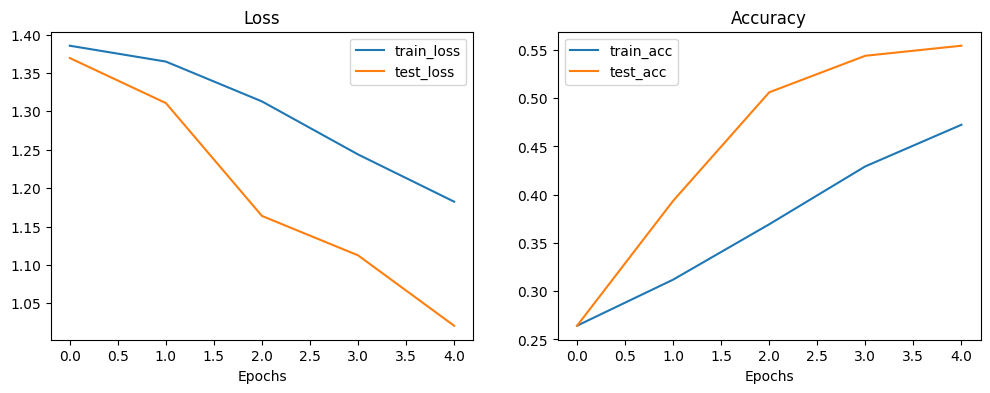

In [ ]:
plot_loss_curves(model_1_results)

## 7. Comparing model results

In [ ]:
import pandas as pd

In [ ]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

display(model_0_df), display(model_1_df)

train_loss  train_acc  test_loss  test_acc
0    1.346388   0.333950   1.276126  0.432018
1    1.214588   0.459566   1.137722  0.514803
2    1.106063   0.526935   1.058505  0.565241
3    1.047066   0.561760   1.002810  0.568531
4    0.976879   0.593442   0.972471  0.615680

train_loss  train_acc  test_loss  test_acc
0    1.385492   0.264300   1.369431  0.264254
1    1.364829   0.312007   1.310777  0.393640
2    1.312937   0.369329   1.163751  0.506031
3    1.243865   0.429302   1.112440  0.543860
4    1.182356   0.472387   1.020747  0.554276

(None, None)

## 7.1 Plot the loss curves together

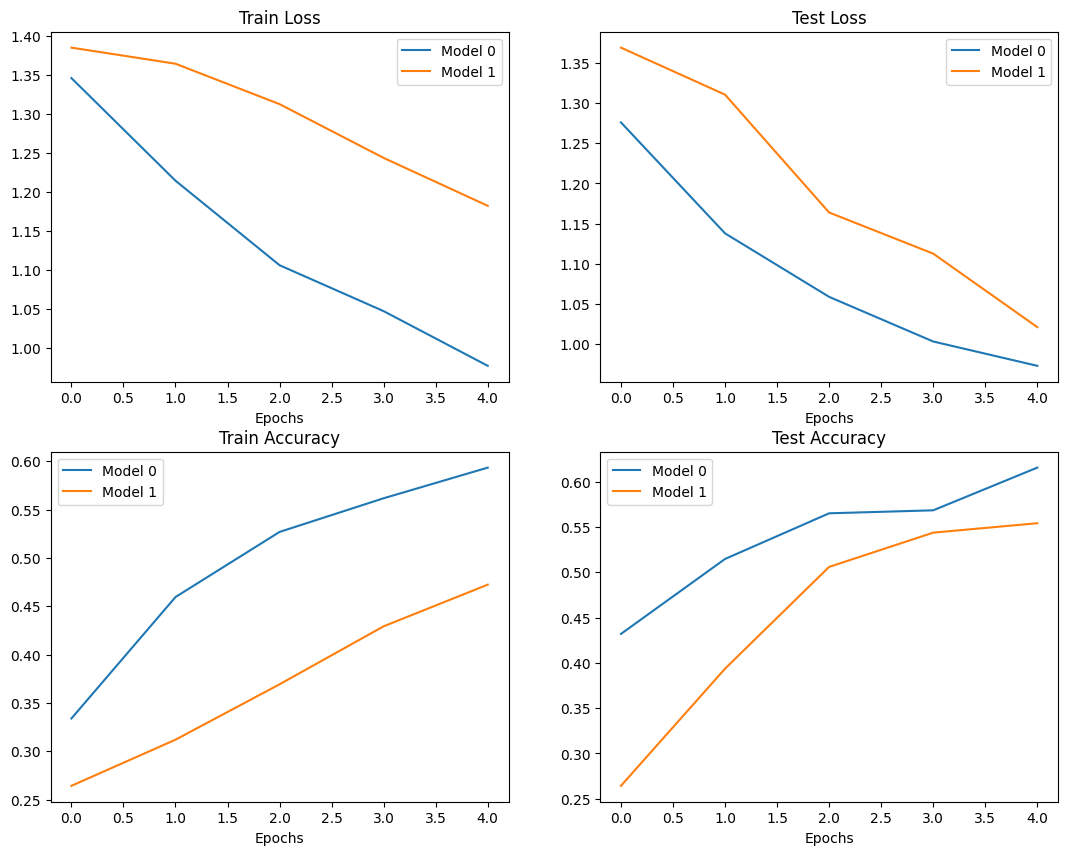

In [ ]:
# Setup a plot
plt.figure(figsize=(13, 10))

epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 8. Making a prediction on a custom image

### 8.1 Download custom images from DuckDuckGo

In [ ]:
try:
    from duckduckgo_search import DDGS
except ModuleNotFoundError:
    print("duckduckgo_search module is not found, downloading...")
    !pip install duckduckgo_search
    from duckduckgo_search import DDGS

duckduckgo_search module is not found, downloading...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.1 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
from io import BytesIO
from PIL import Image
import requests

In [ ]:
custom_image_path = Path("data/custom_image")
custom_image_path.mkdir(parents=True, exist_ok=True)

In [ ]:
import math

def download_images(path: Path,
                    keywords: List[str],
                    filenames: List[str],
                    n=1):
    ddg = DDGS()

    total_n = n * len(keywords)

    plt.figure(figsize=(15, 15))

    ncols = 5
    nrows = math.ceil(total_n / ncols)

    # Search for image results
    for i, keyword in enumerate(keywords):
        results = ddg.images(keyword, max_results=n)

        # Download all the images
        for j, result in enumerate(results):
            while True:
                image_url = result["image"]
                response = requests.get(image_url)
                filename = f"{filenames[i]}_{j}.jpg"
                if response.status_code == 200:
                    image = Image.open(BytesIO(response.content))
                    image_path = path / filenames[i]
                    image_path.mkdir(parents=True, exist_ok=True)
                    image.save(image_path / filename)
                    plt.subplot(nrows, ncols, i * n + j + 1)
                    plt.imshow(image)
                    plt.axis(False)
                    plt.title(filename)
                    print(f"Downloaded image {filename}")
                    break
                else:
                    print(f"Failed to download image {filename}")


Downloaded image cat_0.jpg
Downloaded image chicken_0.jpg
Downloaded image dog_0.jpg
Downloaded image horse_0.jpg


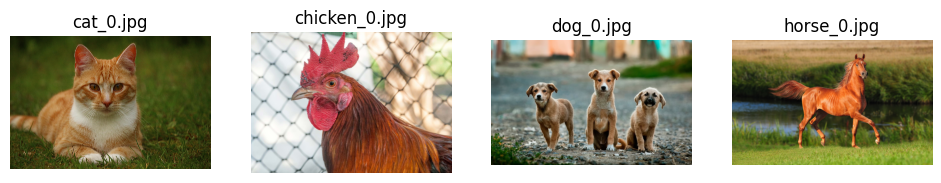

In [ ]:
keywords = ["animal_cat", "animal_chicken", "animal_dog", "animal_horse"]
filenames = ["cat", "chicken", "dog", "horse"]
download_images(custom_image_path, keywords, filenames)

### 8.2 Load the custom imagers with PyTorch

- Convert the images into tensors
- Shape: 64 x 64 x 3
- Use the same device

In [ ]:
import torchvision
import math

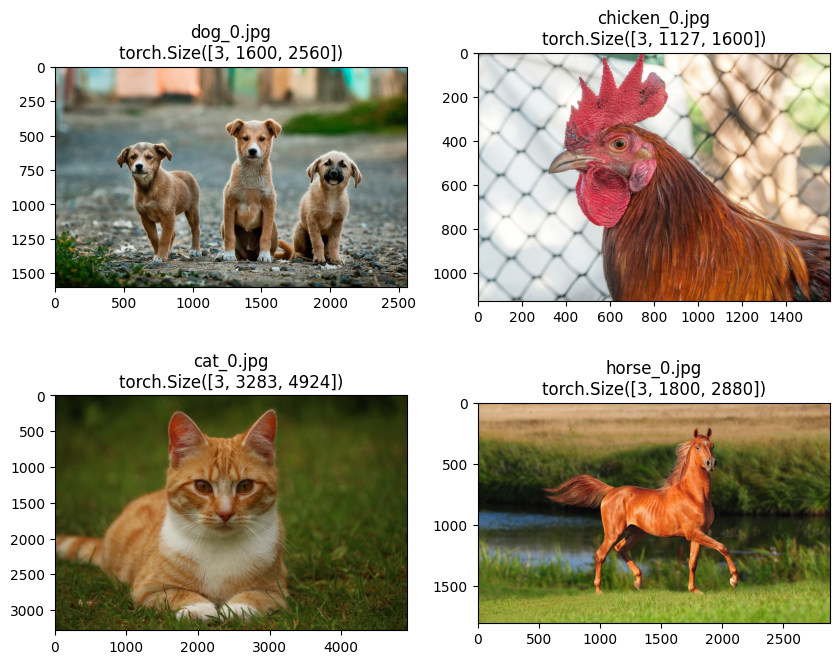

In [ ]:
# Read the custom images
custom_images = list(custom_image_path.rglob("*.*"))
n_images = len(custom_images)
ncols = 2
images_arr = []

plt.figure(figsize=(10, 8))

for i, image in enumerate(custom_images):
    image_arr = torchvision.io.read_image(str(image)).type(torch.float) / 255.0
    images_arr.append(image_arr)
    plt.subplot(math.ceil(n_images / ncols), ncols, i + 1)
    plt.imshow(image_arr.permute(1, 2, 0))
    plt.title(image.name + "\n" + str(image_arr.shape))

### 8.3 Transform the images to be usable by our model

In [ ]:
from torchvision import transforms

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

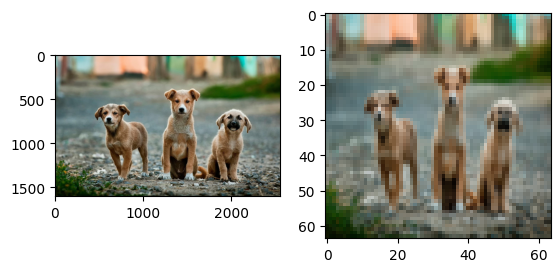

In [ ]:
test_custom_image = images_arr[0]
plt.subplot(1, 2, 1)
plt.imshow(test_custom_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(custom_image_transform(test_custom_image).permute(1, 2, 0))

In [ ]:
transformed_custom_images = torch.stack([custom_image_transform(image) for image in images_arr])
transformed_custom_images.shape

torch.Size([4, 3, 64, 64])

### 8.4 Have fun and make the prediction!

In [ ]:
model_0.eval()
model_1.eval()
with torch.inference_mode():
    model_0_pred = model_0(transformed_custom_images.to(device))
    model_1_pred = model_1(transformed_custom_images.to(device))

model_0_predictions = [class_names[torch.argmax(pred).cpu()] for pred in model_0_pred]
model_1_predictions = [class_names[torch.argmax(pred).cpu()] for pred in model_1_pred]
model_0_predictions, model_1_predictions

(['dog', 'chicken', 'chicken', 'chicken'],
 ['horse', 'chicken', 'dog', 'horse'])

In [ ]:
model_0_pred

tensor([[-0.3715, -1.2072, -0.0936, -0.9567],
        [-1.7491,  0.2143, -1.1315, -2.6701],
        [-0.0146,  0.2933, -0.5611, -1.1477],
        [-2.4027,  1.3751, -1.9222,  0.7242]], device='cuda:0')

### 8.5 Build funcitons to predict custom images

In [ ]:
def read_custom_images(image_path: str):
    custom_images = list(Path(image_path).rglob("*.*"))
    n_images = len(custom_images)
    images_arr = []

    for i, image in enumerate(custom_images):
        image_arr = torchvision.io.read_image(str(image)).type(torch.float) / 255.0
        images_arr.append(image_arr)

    return images_arr

In [ ]:
def predict_images(model: nn.Module,
                   image_path: str,
                   class_names: List[str],
                   transform,
                   device=device):
    # Load the images
    images_arr = read_custom_images(image_path)

    # Transform the images
    if transform:
        batch_images = torch.stack([transform(image) for image in images_arr])
    else:
        batch_images = torch.stack([image for image in images_arr])

    # Make the prediction
    model.to(device)
    model.eval()
    with torch.inference_mode():
        y_pred = model(batch_images.to(device))

    pred_probs = torch.softmax(y_pred, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Plot the predictions
    ncols = 2
    nrows = math.ceil(len(images_arr) / ncols)
    for i, image in enumerate(images_arr):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"{class_names[pred_labels[i].cpu()]} ({pred_probs[i].max().cpu() * 100:.1f}%)")
        plt.axis(False)


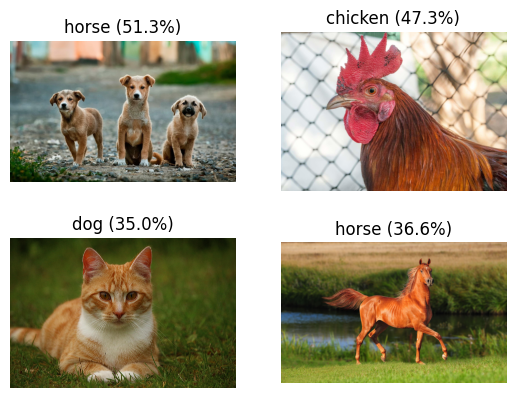

In [ ]:
predict_images(model=model_1,
               image_path=custom_image_path,
               class_names=class_names,
               transform=custom_image_transform,
               device=device)

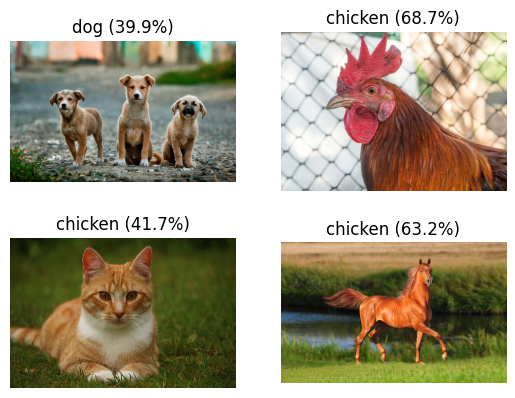

In [ ]:
predict_images(model=model_0,
               image_path=custom_image_path,
               class_names=class_names,
               transform=custom_image_transform,
               device=device)